In [1]:
import numpy as np
from tqdm import tqdm
# import gym
# from gym import spaces

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

from ReplayBuffer import ReplayBuffer
from environment import Environment

In [2]:
device = T.device("cuda" if T.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
#intialise OUACTIONNOISE
class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)





# intialise an actor neural network along with forward pass
class ActorNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, output_dims):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = output_dims
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        # W_init = tf.random_normal_initializer(mean=0, stddev=0.3)
        # b_init = tf.constant_initializer(0.1)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        f3 = 0.003

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        T.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        T.nn.init.uniform_(self.mu.bias.data, -f3, f3)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.to(device)
        
    def forward(self, state):
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.bn2(self.fc2(x)))
        x= T.sigmoid(self.mu(x))
        y=x.clone()
        y[0]=x[0]*20
        y[1]=y[1]*2*T.pi
        y[2]=y[2]*T.pi
        # print(x.shape)
        # print(x)
        # Combine the outputs for each dimension
        return y

# intialise a critic neural network along with forward pass like above
class CriticNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims):
        super(CriticNetwork, self).__init__()
        self.input_dims_state = input_dims[0]
        self.input_dims_action = input_dims[1]
        # print(self.input_dims_state, self.input_dims_action)
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims


        self.fc1_state = nn.Linear(self.input_dims_state, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1_state.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1_state.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1_state.bias.data, -f1, f1)
        self.bn1_state = nn.LayerNorm(self.fc1_dims)

        self.fc1_action = nn.Linear(self.input_dims_action, self.fc1_dims)
        f1_2 = 1./np.sqrt(self.fc1_action.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1_action.weight.data, -f1_2, f1_2)
        T.nn.init.uniform_(self.fc1_action.bias.data, -f1_2, f1_2)
        self.bn1_action = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(2*self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.action_value = nn.Linear(self.fc2_dims,1)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.to(device)
        
    def forward(self, state, action):
        state_input = F.relu(self.bn1_state(self.fc1_state(state)))
        action_input = F.relu(self.bn1_action(self.fc1_action(action)))
        # print(state_input.shape, action_input.shape)
        # Concatenate state and action inputs
        x = T.cat((state_input, action_input), dim=1)
        
        # concatinate state and action into a new tensor
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.action_value(x)
        
        return x
    
# intialise the agent class
class DDPG_Agent(object):
    def __init__(self, alpha, beta, input_dims_actor,input_dims_critic,input_dims_buff,tau=0.9, gamma=0.99, n_actions=3, max_size=1000, layer1_size=40
                 , layer2_size=30, batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims_buff)
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.actor = ActorNetwork(alpha,input_dims_actor, layer1_size, layer2_size, output_dims=n_actions)
        self.critic = CriticNetwork(beta,input_dims_critic, layer1_size, layer2_size)
        self.target_actor = ActorNetwork(alpha,input_dims_actor, layer1_size, layer2_size, output_dims=n_actions)
        self.target_critic = CriticNetwork(beta, input_dims_critic, layer1_size, layer2_size)
        
        self.noise = OUActionNoise(mu=np.zeros(n_actions))
        
        self.update_network_parameters(tau=1)
        
    def choose_action(self, observation):
        self.actor.eval()
        observation = T.tensor(observation, dtype=T.float).to(device)
        mu = self.actor.forward(observation).to(device)
        mu_prime = mu + T.tensor(self.noise(), 
                                 dtype=T.float).to(device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()
    
    def remember(self, state, action, reward, new_state, done):
        self.memory.add_sample(state, action, reward, new_state, done)
    
    def learn(self, num_step):
        if self.memory.count < self.batch_size:
            return
        
        states, actions, rewards, new_states, dones = self.memory.return_sample(self.batch_size)
        
        states = T.tensor(states, dtype=T.float).to(device)
        actions = T.tensor(actions, dtype=T.float).to(device)
        rewards = T.tensor(rewards, dtype=T.float).to(device)
        new_states = T.tensor(new_states, dtype=T.float).to(device)
        dones = T.tensor(dones).to(device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        
        target_actions = self.target_actor.forward(new_states)
        # print(target_actions.shape)
        # print(new_states.shape)
        target_critics = self.target_critic.forward(new_states, target_actions)
        critic_value = self.critic.forward(states, actions)
        

        y = []
        for j in range(self.batch_size):
            y.append(rewards[j] + self.gamma*target_critics[j]*dones[j])
        y = T.tensor(y).to(device)
        y = y.view(self.batch_size, 1)
        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(critic_value, y)
        critic_loss.backward()
        self.critic.optimizer.step()


        
       
        self.critic.eval()
        self.actor.eval()
        p = -self.critic.forward(states, self.actor.forward(states))
        self.actor.train()
        self.actor.optimizer.zero_grad()
        actor_loss = T.mean(p)
        actor_loss.backward()
        self.actor.optimizer.step()
        if num_step == 0:
            self.update_network_parameters()

        
    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + (1-tau)*target_critic_dict[name].clone()

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + (1-tau)*target_actor_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)








In [4]:

agent = DDPG_Agent(alpha=0.0001, beta=0.001, input_dims_actor=[6], input_dims_critic=[6,3], input_dims_buff=[6,3], tau=0.01, gamma=0.9,batch_size=64, layer1_size=512, layer2_size=512, n_actions=3)
env = Environment(state = np.array([0, 1, 0, -1, 0, 0]), mu = 0.05, m = 1, g = 9.8, thetamin = 0, thetamax = np.pi, phimin = 0, phimax = 2*np.pi, Tmin = 0, Tmax = 20, dt = 0.02, dphi = 0.0175, dtheta = 0.0175)
np.random.seed(0)

Average_Rewards = []
for i in range(50):
    env.reset()
    done = False
    score = 0
    its = 0
    total_reward = []
    while not done and its<3000:
        act = agent.choose_action(env.state)
        # print(act)
        state, new_state, reward, done = env.infostep(its,act)
        agent.remember(state, act, reward, new_state, int(done))
        agent.learn(its%18)
        total_reward.append(reward)
        its+=1
        
    tr = 0
    for r in total_reward[::-1]:
        tr = agent.gamma*tr + r
    # tr = tr/its 
    Average_Rewards.append(tr)

    print('episode ', i, 'score %.1f' % tr)





episode  0 score -209.1
episode  1 score -208.1
episode  2 score -202.3
episode  3 score -215.3
episode  4 score -216.7
episode  5 score -217.6
episode  6 score -217.5
episode  7 score -217.6
episode  8 score -216.8
episode  9 score -217.7
episode  10 score -217.3
episode  11 score -215.7
episode  12 score -217.0
episode  13 score -217.3
episode  14 score -216.9
episode  15 score -216.3
episode  16 score -217.6
episode  17 score -217.8
episode  18 score -217.8
episode  19 score -217.7
episode  20 score -217.3
episode  21 score -217.4
episode  22 score -217.1
episode  23 score -217.1
episode  24 score -217.7
episode  25 score -217.4
episode  26 score -215.9
episode  27 score -217.1
episode  28 score -217.1
episode  29 score -217.6
episode  30 score -216.5
episode  31 score -217.1
episode  32 score -216.8
episode  33 score -216.7
episode  34 score -217.4
episode  35 score -217.7
episode  36 score -217.5
episode  37 score -216.8
episode  38 score -217.8
episode  39 score -216.9
episode  4

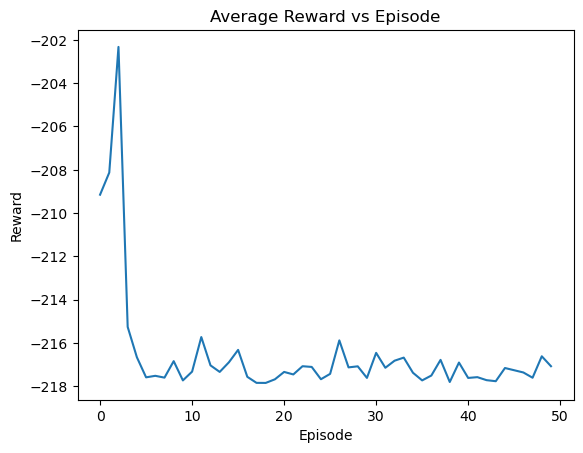

In [5]:
plt.plot(np.arange(len(Average_Rewards)), Average_Rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average Reward vs Episode')
plt.show()

In [6]:
def plot_trajectory(states):
    x = [state[0] for state in states]
    y = [state[2] for state in states]
    z = [state[4] for state in states]


    plt.subplot(1, 2, 1)
    plt.plot(x, y, 'r.-')
    plt.title('X vs Y')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Plotting x vs z
    plt.subplot(1, 2, 2)
    plt.plot(z, 'g.-')
    plt.title(' Z')

    plt.tight_layout()
    plt.show()

In [7]:
def plot_actions(actions):
    T_values = [action[0] for action in actions]
    phi_values = [action[1] for action in actions]
    theta_values = [action[2] for action in actions]

    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    axs[0].plot(range(len(T_values)), T_values)
    axs[0].set_ylabel('T')
    axs[0].set_title('Trajectory of T')
    axs[0].set_ylim(env.Tmin, env.Tmax)

    axs[1].plot(range(len(phi_values)), phi_values)
    axs[1].set_ylabel('phi')
    axs[1].set_title('Trajectory of phi')
    axs[1].set_ylim(env.phimin, env.phimax)

    axs[2].plot(range(len(theta_values)), theta_values)
    axs[2].set_ylabel('theta')
    axs[2].set_title('Trajectory of theta')
    axs[2].set_ylim(env.thetamin, env.thetamax)

    plt.xlabel('Time Step')
    plt.tight_layout()
    plt.show()

30001


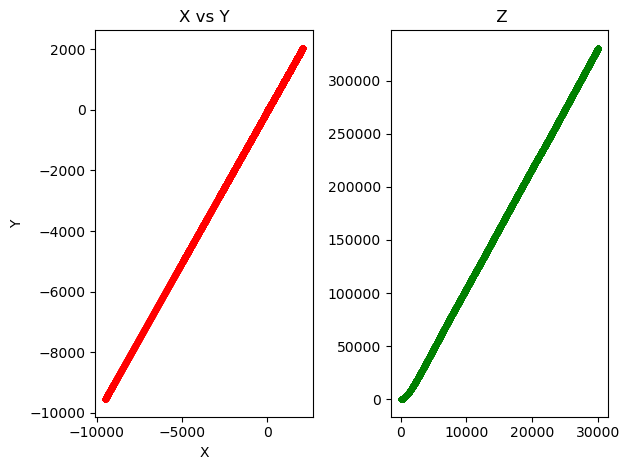

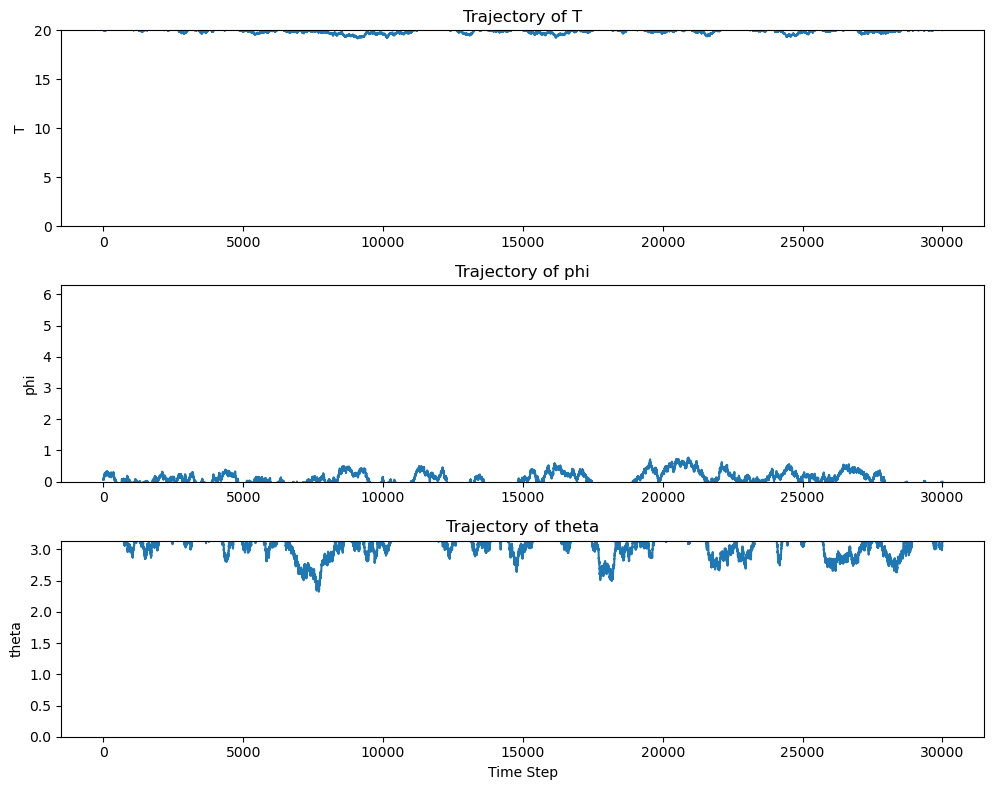

In [8]:
state = [0, 1, 0, -1, 0, 0]
done = False
score = 0
its = 0
states = []
actions = []
env.reset()
states.append(env.state)
while not done and its<30000:
    act = agent.choose_action(env.state)
    # print(act)
    actions.append(act)
    state,new_state, reward, done = env.infostep(its,act)
    states.append(env.state)
    score+=reward
    its+=1

print(len(states))

states = np.array(states)
actions = np.array(actions)
# save these two arrays to a file
np.save('states_DDPG.npy', states)
np.save('actions_DDPG.npy', actions)

plot_trajectory(states)
plot_actions(actions)